# Preamble

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import csv

The function "choose_LEEM_type" allows one to choose different LEEM parameters and define them globally. To customize the parameters, edit the function.

Input: __LEEM_type__ and __aberration_corrected__.

Output: Globally defined set of parameters. 

|Variable|Parameter|
|---|---|
|__LEEM_type__|Choose "IBM" or customize using "Energy dependent"|
|__aberration_corrected__|Boolean|
|E|Accelerating Energy|
|E_0|Energy at surface|
|lamda|wavelength after acceleration|
|lamda_0|wavelength at surface|
|C_c|2nd rank chromatic aberation coefficient|
|C_cc|3rd rank chromatic aberation coefficient|
|C_3c|4th rank chromatic aberation coefficient|
|C_3|3rd order spherical aberration coefficient|
|C_5|5th order spherical aberration coefficient|
|alpha_ap|Aperature angle|
|alpha_ill|Illumination angle| 
|delta_E|Energy spread of the input Gaussian beam|
|M_L|Magnification|
|q_ill|Illuminating wave number|
|q_ap|Wave number limited by the aperture|

In [3]:
def choose_LEEM_type(LEEM_type_str, aberration_corrected_bool = False):
    global E, E_0, C_c, C_cc, C_3c, C_3, C_5, alpha_ap, alpha_ill, \
        delta_E, M_L, lamda, lamda_0, q_ill, q_ap, LEEM_type, aberration_corrected
    LEEM_type = LEEM_type_str
    aberration_corrected = aberration_corrected_bool
    
    if LEEM_type == "IBM":
        if aberration_corrected == False:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 10  # eV  Energy at the sample
            
            C_c = -0.075  # m  Second Rank Chromatic Aberration Coefficient
            C_cc = 23.09 # m   Third Rank Chromatic Aberration Coefficient
            C_3c = -59.37  # m   Forth Rank Chromatic Aberration Coefficient
            
            C_3 = 0.345  # m  Third Order Spherical Aberration Coefficient
            C_5 = 39.4  # m  Fifth Order Spherical Aberration Coefficient
            
            alpha_ap = 2.34e-3  # rad Aperture angle
            alpha_ill = 0.1e-3  # rad Illumination Divergence Angle
            
            delta_E = 0.25  # eV  Energy Spread
            M_L = 0.653  # Lateral Magnification
            
        elif aberration_corrected == True:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 10  # eV  Energy at the sample
            
            C_c = 0  # m   Second Rank Chromatic Aberration Coefficient
            C_cc = 27.9 # m   Third Rank Chromatic Aberration Coefficient
            C_3c = -67.4 # m   Forth Rank Chromatic Aberration Coefficient
            
            C_3 = 0  # m   Spherical Aberration Coefficient
            C_5 = 92.8
        
            alpha_ap = 7.37e-3  # rad Aperture angle
            alpha_ill = 0.1e-3  # rad Illumination Divergence Angle
        
            delta_E = 0.25  # eV  Energy Spread
            M_L = 0.653  # Lateral Magnification
            
        lamda = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E)
        lamda_0 = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E_0)
    
        q_ap = alpha_ap/lamda
        q_ill = alpha_ill/lamda
        
    elif LEEM_type == "Energy dependent":
        if aberration_corrected == False:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 20 # eV  Energy at the sample ##########CUSTOMIZABLE INPUT##########
            kappa = np.sqrt(E/E_0)
            
            C_c = -0.0121 * kappa**(1/2) + 0.0029 # m  Second Rank Chromatic Aberration Coefficient
            C_cc = 0.5918 * kappa**(3/2) - 87.063 # m   Third Rank Chromatic Aberration Coefficient
            C_3c = -1.2141 * kappa**(3/2) + 169.41  # m   Forth Rank Chromatic Aberration Coefficient
            
            C_3 = 0.0297 * kappa**(1/2) + 0.1626  # m  Third Order Spherical Aberration Coefficient
            C_5 = 0.6223 * kappa**(3/2) - 79.305  # m  Fifth Order Spherical Aberration Coefficient
            
            delta_E = 0.25  # eV  Energy Spread
            alpha_ill = 0.1e-3  # rad Illumination divergence angle
            M_L = 0.653  # Lateral Magnification
            
            lamda = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E) # in metre
            alpha_ap = (lamda/C_3)**(1/4) # rad Aperture angle for optimal resolution
            
        if aberration_corrected == True:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 20 # eV  Energy at the sample
            kappa = np.sqrt(E/E_0)
            
            C_c = 0 # m  Second Rank Chromatic Aberration Coefficient
            C_cc = 0.5984 * kappa**(3/2) - 84.002 # m   Third Rank Chromatic Aberration Coefficient 
            C_3c = -1.1652 * kappa**(3/2) + 153.58  # m   Forth Rank Chromatic Aberration Coefficient  
            
            C_3 = 0  # m  Third Order Spherical Aberration Coefficient
            C_5 = 0.5624 * kappa**(3/2) - 16.541  # m  Fifth Order Spherical Aberration Coefficient
            
            delta_E = 0.25  # eV  Energy Spread
            alpha_ill = 0.1e-3  # rad Illumination divergence angle
            M_L = 0.653  # Lateral Magnification
            
            lamda = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E) # in metre
            alpha_ap = (3/2*lamda/C_5)**(1/6) # rad Aperture angle for optimal resolution 
        
        lamda_0 = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E_0) # in metre
        
        q_ap = alpha_ap/lamda
        q_ill = alpha_ill/lamda

A function to set different defocus values

In [5]:
def choose_defocus(defocus_type, value = 0):
    if defocus_type == "In-focus":
        delta_z = 0
    elif defocus_type == "Scherzer defocus":
        delta_z = np.sqrt(3/2*C_3*lamda)
    elif defocus_type == "A-Phi Scherzer defocus":
        delta_z = np.sqrt(9/64*C_5*lamda**2)
    elif defocus_type == "custom":
        delta_z = value
    return delta_z

A function to choose different sample object functions

    """
    :param object_type_str: Type of object, can take "Step amplitude object", "Step phase object" 
    :param k: phase of object if it is of type "Step phase object"
    """

In [6]:
def create_object(object_type_str, k = 1):
    global object_type, object_function, object_amplitude, object_phase
    object_type = object_type_str
    if object_type == "Step amplitude object":
    # Creating an 1:1/sqrt(2) step amplitude object whose phase is uniformly set to 0
        object_phase = np.zeros_like(x_array)
        
        object_amplitude = np.ones_like(x_array)
        
        for counter, element in enumerate(x_array):
            if element > 0:
                object_amplitude[counter] = 1/np.sqrt(2)
    
    if object_type == "Step phase object":
    # Creating a k.pi step phase object whose amplitude is uniformly set to 1        
        object_amplitude = np.ones_like(x_array)
        
        object_phase = np.zeros_like(x_array)
        
        for counter, element in enumerate(x_array):
            if element > 0:
                object_phase[counter] = k * np.pi
     
    # Object function
    object_function = np.multiply(object_amplitude, np.exp(1j * object_phase))


Setup for the simulation

In [7]:
object_size = 400               # simulating object size in nm
simulating_steps = 1 + 2**12   # total simulating steps
# An array of points in the x space
x_array = (np.linspace(-object_size/2, object_size/2, simulating_steps) + object_size/simulating_steps)*1e-9

# choose parameters
choose_LEEM_type("IBM", aberration_corrected_bool = False)

# choose defocus
delta_z = choose_defocus("In-focus")

# create object
create_object("Step phase object", k = 1)

# The object image is reversed through the lens
object_function_reversed = object_function[::-1] 

In [9]:
# Creating an array of different delta z
delta_z_series = [0]
# delta_z_series = np.linspace(-1.8*(C_3*lamda)**(1/2), 2.2*(C_3*lamda)**(1/2), 64)

Main function to simulate the object for the series of aperture angles, using source of Gaussian spread

In [11]:
def get_image_Gaussian(delta_z, delta_z_index):    
    matrixI = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
    # The Fourier Transform of the Object Wave Function
    F_object_function = np.fft.fft(object_function_reversed, simulating_steps) * (1 / simulating_steps)
    # Shifting this to the centre at 0
    F_object_function = np.fft.fftshift(F_object_function)
    # An array of points in the q space, in SI unit
    q = 1 / (simulating_steps* (x_array[1] - x_array[0])) * np.arange(0, simulating_steps, 1)
    # Shifting the q array to centre at 0 
    q = q - np.max(q) / 2
    
    # Taking into account the effect of the contrast aperture    
    a = np.sum(np.abs(q) <= q_ap)
    if len(q) > a:
        min_index = int(np.ceil(simulating_steps / 2 + 1 - (a - 1) / 2))
        max_index = int(np.floor(simulating_steps / 2 + 1 + (a + 1) / 2))
        q = q[min_index:max_index]
        F_object_function = F_object_function[min_index:max_index]
        
    # Arrays for the calculation of the double integration 
    Q, QQ = np.meshgrid(q, q)
    F_obj_q, F_obj_qq = np.meshgrid(F_object_function, np.conj(F_object_function))
    
    # The modifying function of zeroth-order
    R_0 = np.exp(1j*2*np.pi*(C_3*lamda**3 * (Q**4 - QQ**4)/4 + C_5*lamda**5 *(
        Q**6 - QQ**6)/6 - delta_z*lamda*(Q**2 - QQ**2)/2))
    
    delta_E = 0.2424 # eV
    sigma_E = delta_E/(2*np.sqrt(2*np.log(2)))
    sigma_ill = q_ill/(2*np.sqrt(2*np.log(2)))
    
    a_1 = C_3*lamda**3 *(Q**3 - QQ**3) + C_5*lamda**5 * (Q**5 - QQ**5) - delta_z*lamda*(Q - QQ)
    
    b_1 = 1/2*C_c*lamda*(Q**2 - QQ**2)/E + 1/4*C_3c*lamda**3*(Q**4 - QQ**4)/E
    b_2 = 1/2*C_cc*lamda*(Q**2 - QQ**2)/E**2
    
    # The envelop function by source extension
    E_s = np.exp(-2*np.pi**2 *sigma_ill**2 *a_1**2)
    
    # The purely chromatic envelop functions
    E_cc = (1 - 1j*4*np.pi*b_2*sigma_E**2)**(-1/2)
    E_ct = E_cc * np.exp(-2*np.pi**2 *E_cc**2 *sigma_E**2 *b_1**2)
    
    AR = np.multiply(np.multiply(np.multiply(np.multiply(F_obj_q, F_obj_qq), R_0), E_s), E_ct)
    for i in range(len(q)):
        for j in range(i + 1, len(q)):
            matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + 2 * (
                    AR[j][i] * np.exp(1j * 2 * np.pi * (Q[j][i] - QQ[j][i]) * x_array)).real
        

    matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + np.trace(AR) * np.ones_like(x_array)

    return matrixI

In [12]:
def get_image_field_emission(delta_z, delta_z_index):
    matrixI = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
    # The Fourier Transform of the Object Wave Function
    F_object_function = np.fft.fft(object_function_reversed, simulating_steps) * (1 / simulating_steps)
    # Shifting this to the centre at 0
    F_object_function = np.fft.fftshift(F_object_function)
    # An array of points in the q space, in SI unit
    q = 1 / (simulating_steps* (x_array[1] - x_array[0])) * np.arange(0, simulating_steps, 1)
    # Shifting the q array to centre at 0 
    q = q - np.max(q) / 2
    
    # Taking into account the effect of the contrast aperture    
    a = np.sum(np.abs(q) <= q_ap)
    if len(q) > a:
        min_index = int(np.ceil(simulating_steps / 2 + 1 - (a - 1) / 2))
        max_index = int(np.floor(simulating_steps / 2 + 1 + (a + 1) / 2))
        q = q[min_index:max_index]
        F_object_function = F_object_function[min_index:max_index]
        
    # Arrays for the calculation of the double integration 
    Q, QQ = np.meshgrid(q, q)
    F_obj_q, F_obj_qq = np.meshgrid(F_object_function, np.conj(F_object_function))
    
    # The modifying function of zeroth-order
    R_0 = np.exp(1j*2*np.pi*(C_3*lamda**3 * (Q**4 - QQ**4)/4 + C_5*lamda**5 *(
        Q**6 - QQ**6)/6 - delta_z*lamda*(Q**2 - QQ**2)/2))
    
    sigma_E1 = 0.0531  # eV
    sigma_E2 = 0.1991  # eV
    sigma_E3 = 0.0962  # eV
    epsilon_1 = -0.03925 # eV
    epsilon_2 = -0.3382  # eV
    epsilon_3 = -0.1438  # eV
    mu_1 = 0.28682
    mu_2 = 0.33146
    mu_3 = 0.38173
    
    sigma_ill = q_ill/(2*np.sqrt(2*np.log(2)))
    
    a_1 = C_3*lamda**3 *(Q**3 - QQ**3) + C_5*lamda**5 * (Q**5 - QQ**5) - delta_z*lamda*(Q - QQ)
    
    b_1 = 1/2*C_c*lamda*(Q**2 - QQ**2)/E + 1/4*C_3c*lamda**3*(Q**4 - QQ**4)/E
    b_2 = 1/2*C_cc*lamda*(Q**2 - QQ**2)/E**2
    
    c_1 = b_1 - 1j*epsilon_1/(2*np.pi*sigma_E1**2)
    c_2 = b_1 - 1j*epsilon_2/(2*np.pi*sigma_E2**2)
    c_3 = b_1 - 1j*epsilon_3/(2*np.pi*sigma_E3**2)
    
    # The envelop function by source extension
    E_s = np.exp(-2*np.pi**2 *sigma_ill**2 *a_1**2)
    
    ## The chromatic envelop functions for the 1st Gaussian distribution  
    E_cc1 = (1 - 1j*4*np.pi*b_2*sigma_E1**2)**(-1/2)
    E_ct1 = E_cc1 * np.exp(-2*np.pi**2 *E_cc1**2 *sigma_E1**2 *c_1**2) * np.exp(- epsilon_1**2/(2*sigma_E1**2))
    
    ## The chromatic envelop functions for the 2nd Gaussian distribution  
    E_cc2 = (1 - 1j*4*np.pi*b_2*sigma_E2**2)**(-1/2)
    E_ct2 = E_cc2 * np.exp(-2*np.pi**2 *E_cc2**2 *sigma_E2**2 *c_2**2) * np.exp(- epsilon_2**2/(2*sigma_E2**2))
    
    ## The chromatic envelop functions for the 3rd Gaussian distribution  
    E_cc3 = (1 - 1j*4*np.pi*b_2*sigma_E3**2)**(-1/2)
    E_ct3 = E_cc3 * np.exp(-2*np.pi**2 *E_cc3**2 *sigma_E3**2 *c_3**2) * np.exp(- epsilon_3**2/(2*sigma_E3**2))
    
    # The total chromatic envelop functions
    E_ctot = mu_1*E_ct1 + mu_2*E_ct2 + mu_3*E_ct3
    
    AR = np.multiply(np.multiply(np.multiply(np.multiply(F_obj_q, F_obj_qq), R_0), E_s), E_ctot)
    for i in range(len(q)):
        for j in range(i + 1, len(q)):
            matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + 2 * (
                    AR[j][i] * np.exp(1j * 2 * np.pi * (Q[j][i] - QQ[j][i]) * x_array)).real
        

    matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + np.trace(AR) * np.ones_like(x_array)

    return matrixI

# Simulation

In [16]:
print("Gaussian Simulation start.")
t_0 = time.time()

matrixI1 = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)

with Parallel(n_jobs=-1, verbose=50, max_nbytes="50M") as parallel:
    parallelResult = parallel(delayed(get_image_Gaussian)(delta_z, delta_z_index) for delta_z_index, delta_z in enumerate(delta_z_series))

for mat in parallelResult:
    matrixI1 = matrixI1 + mat

matrixI1 = np.abs(matrixI1)

print('Simulation finished.')
print('Total time: ' + str(round((time.time()-t_0)/60, 3)) + ' minutes')

Simulation start.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
Simulation finished.
Total time: 0.04 minutes


In [17]:
print("Field Emission Simulation start.")
t_0 = time.time()

matrixI2 = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)

with Parallel(n_jobs=-1, verbose=50, max_nbytes="50M") as parallel:
    parallelResult = parallel(delayed(get_image_field_emission)(delta_z, delta_z_index) for delta_z_index, delta_z in enumerate(delta_z_series))

for mat in parallelResult:
    matrixI2 = matrixI2 + mat

matrixI2 = np.abs(matrixI2)

print('Simulation finished.')
print('Total time: ' + str(round((time.time()-t_0)/60, 3)) + ' minutes')

Simulation start.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
Simulation finished.
Total time: 0.039 minutes


# Result Analysis

Plotting the simulated images

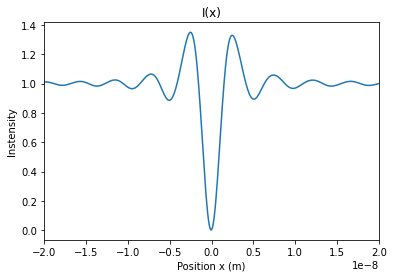

In [20]:
for i in range(len(delta_z_series)):
    plt.plot(x_array, matrixI1[:, i])
    plt.xlim(-20e-9, 20e-9)
    plt.xlabel('Position x (m)')
    plt.ylabel('Instensity')
    plt.title('I(x)')
    
    plt.show()

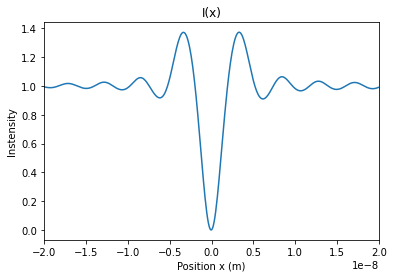

In [22]:
for i in range(len(delta_z_series)):
    plt.plot(x_array, matrixI2[:, i])
    plt.xlim(-20e-9, 20e-9)
    plt.xlabel('Position x (m)')
    plt.ylabel('Instensity')
    plt.title('I(x)')
    
    plt.show()

Find the resolution

In [33]:
# Create a list of resolutions corresponding to different aperture angles
resolution_list = []
for i in range(len(alpha_ap_series)):
    matrixI_i = matrixI[:, i]
    
    if object_type == "Step amplitude object" or object_type == "Error function amplitude object":
        half_steps = int(simulating_steps/2)
        # Starting from the centre and find the local minimum to the right of the central point
        I_min = matrixI_i[half_steps]
        for j in range(1, half_steps):
            if matrixI_i[half_steps+j] < I_min:
                I_min = matrixI_i[half_steps+j]
            else:
                idx_min = half_steps+j-1
                break
            
        # Starting from the centre and find the local maximum to the left of the central point
        I_max = matrixI_i[half_steps]
        for j in range(1, half_steps):
            if matrixI_i[half_steps-j] > I_max:
                I_max = matrixI_i[half_steps-j]            
            else:
                idx_max = half_steps-j+1
                break
            
        
        # The region of interest to find the resolution
        x_array_focus = x_array[idx_max:idx_min]
        matrixI_focus = matrixI_i[idx_max:idx_min]
        
        I_100_index = np.argmin(np.abs(matrixI_focus - 1))
        I_100 = matrixI_focus[I_100_index]
        I_0_index = np.argmin(np.abs(matrixI_focus - 1/2))
        I_0 = matrixI_focus[I_0_index]
        
        I_84 = I_0 + (I_100 - I_0)*84/100
        I_16 = I_0 + (I_100 - I_0)*16/100
        
        I_84_index = np.argmin(np.abs(matrixI_focus - I_84))
        x_84 = x_array_focus[I_84_index]
        I_16_index = np.argmin(np.abs(matrixI_focus - I_16))
        x_16 = x_array_focus[I_16_index]
        resolution_i = x_16 - x_84
    
    if object_type == "Step phase object" or object_type == "Error function phase object":
        # Finding the local minimum around the central point
        half_steps = int(simulating_steps/2)
        I_min = matrixI_i[half_steps]
        for j in range(1, half_steps):
            if matrixI_i[half_steps+j] < I_min:
                I_min = matrixI_i[half_steps+j]
            else:
                idx_min = half_steps+j-1
                break
        
        current_min_idx = idx_min
        for j in range(1, half_steps):
            if matrixI_i[current_min_idx-j] < I_min:
                I_min = matrixI_i[current_min_idx-j]
            else:
                idx_min = current_min_idx-j+1
                break
        
        # Finding the local maximum to the right of this minimum
        I_right = matrixI_i[idx_min]
        for j in range(1, half_steps):
            if matrixI_i[idx_min+j] > I_right:
                I_right = matrixI_i[idx_min+j]
            else:
                idx_right = idx_min+j-1
                break
            
        # Finding the local maximum to the left of this minimum
        I_left = matrixI_i[idx_min]
        for j in range(1, half_steps):
            if matrixI_i[idx_min-j] > I_left:
                I_left = matrixI_i[idx_min-j]            
            else:
                idx_left = idx_min-j+1
                break
            
        # The dip is counted from the lower value between I_left and I_right
        if I_left > I_right:
            idx_left = idx_left + np.argmin(np.abs(matrixI_i[idx_left:idx_min] - I_right))
            I_left = matrixI_i[idx_left]
        elif I_left < I_right:
            idx_right = idx_min + np.argmin(np.abs(matrixI_i[idx_min:idx_right] - I_left))
            I_right = matrixI_i[idx_right]    
            
        # Shifting the left and right points of consideration to those of value 1
        I_left_index = np.argmin(np.abs(matrixI_i[idx_left:idx_min] - 1))
        I_left = matrixI_i[idx_left]
        I_right_index = np.argmin(np.abs(matrixI_i[idx_min:idx_right] - 1))
        I_right = matrixI_i[idx_right]
        
        I_50left = I_min + (I_left - I_min)/2
        I_50right = I_min + (I_right - I_min)/2
        
        I_50left_index = idx_left + np.argmin(np.abs(matrixI_i[idx_left:idx_min] - I_50left))
        x_50left = x_array[I_50left_index]
        I_50right_index = idx_min + np.argmin(np.abs(matrixI_i[idx_min:idx_right] - I_50right))
        x_50right = x_array[I_50right_index]
        resolution_i = x_50right - x_50left
        
        
    resolution_list.append(resolution_i)

resolution_list

[2.24609375e-09]

Plot resolution versus aperture angle

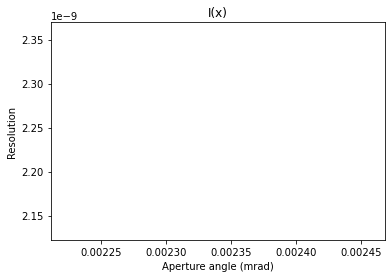

In [32]:
plt.plot(alpha_ap_series, resolution_list)
plt.xlabel('Aperture angle (mrad)')
plt.ylabel('Resolution')
plt.title('I(x)')

plt.show()

Save this list of resolution into a csv file

In [30]:
if aberration_corrected == False:
    filename = object_type + '_R(a)_IBM_nac.csv' 
if aberration_corrected == True:
    filename = object_type + '_R(a)_IBM_ac.csv'

with open(filename, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Aperture angle (mrad)', 'Resolution (nm)'])
    
    for i in range(len(alpha_ap_series)):
        writer.writerow([round(alpha_ap_series[i], 3), round(1e9 * resolution_list[i], 10)])
 
    csvfile.close()
    
with open('data.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Aperture angle (mrad)', 'Resolution (nm)'])
    
    for i in range(len(alpha_ap_series)):
        writer.writerow([round(alpha_ap_series[i], 3), round(1e9 * resolution_list[i], 10)])
 
    csvfile.close()